In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.linalg as scl

from msmtools.analysis.dense.pcca import _pcca_connected_isa

In this notebook, we will apply EDMD to analyze a diffusion in a two-well potential
$$ \mathrm{d}X_t = - V'(X_t) \mathrm{d}t + \sqrt{2} \mathrm{d}W_t $$
$$ V(x) = (x^2 - 1)^2. $$

### Simulation and Evolution of Densities
Let's repeat what we did for the previous example: we set up the numerical integrator, and then have a look at the evolution of probability distributions with time.

In [2]:
# This function realizes the standard Euler scheme
# for a stochastic differential equation in 1d:
def Euler_Scheme(x0, b, sigma, dt, ntraj, m):
    # Prepare output:
    y = np.zeros((ntraj, m))
    y[:, 0] = x0
    # Initialize at x0:
    x = x0
    # Integrate:
    for kk in range(1, m):
        # Update:
        xn = x + dt * b(x) + sigma(x) * np.sqrt(dt)* np.random.randn(ntraj)
        # Update current state:
        y[:, kk] = xn
        x = xn
    return y

In [3]:
D = 0.5
# Drift
def _b(x):
    return -2*(x**2 - 1.0) * 2*x

# Diffusion:
def _sigma(x):
    return np.sqrt(2*D)

Use the above function to produce 1000 simulations, each comprising discrete 100 steps, at integration time step 1e-2, starting from uniformly drawn initial conditions in $[-1.5, 1.5]$. Produce a histogram of the data after $[1, 10, 20, 50, 100]$ steps.

In [4]:
# Settings:
m = 50000
dt = 1e-3
ntraj = 1000

# Generate data:
x0 = -1.0
X = Euler_Scheme(x0, _b, _sigma, dt, ntraj, m)

Text(0.5, 1.0, 'Time Evolution of Distribution')

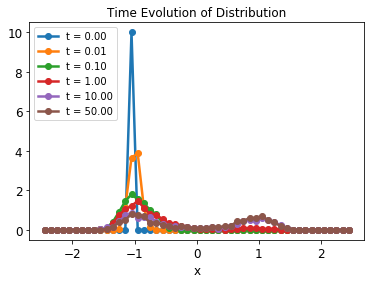

In [5]:
# Time instances to be used for histogramming:
t_vec = np.array([1, 10, 100, 1000, 10000, 50000])
# Bins for histogram:
xe = np.arange(-2.5, 2.51, 0.1)
xc = 0.5 * (xe[1:] + xe[:-1])

# Histogram the data at different time instances:
plt.figure()

qq = 0
for t in t_vec:
    h, _ = np.histogram(X[:, t-1], bins=xe, density=True)
    plt.plot(xc, h, "o-", linewidth=2.5, label="t = %.2f"%(dt * (t)))

plt.xlabel("x", fontsize=12)
plt.tick_params(labelsize=12)
plt.legend(loc=2)
plt.title("Time Evolution of Distribution")

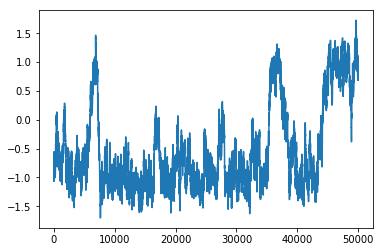

In [6]:
plt.plot(X[0, :])

### Estimating the Koopman Operator

In [7]:
def _compute_UL(G, A, tol):
    U = _transform_ortho(G, tol)
    L = np.dot(U.T, np.dot(A, U))
    return U, L
    

def _transform_ortho(G, tol):
    # Eigenvalue decomposition:
    s, U = scl.eigh(G)
    # Sort in decreasing order
    s = s[::-1]
    U = U[:, ::-1]
    # Elminate small singular values:
    ind = np.where(s / s[0] >= tol)[0]
    s = s[ind]
    U = U[:, ind]
    # Return transformation matrix:
    return np.dot(U, np.diag(s ** (-0.5)))

In [8]:
def koopman_matrix_reduced(X, Y, psi, tol=1e-10):
    # Evaluate basis set on full data:
    PX = psi(X)
    PY = psi(Y)
    # Compute Koopman matrix:
    G = np.dot(PX, PX.T)
    A = np.dot(PX, PY.T)
    L, K = _compute_UL(G, A, tol)
    return L, K

Produce a long simulation of $50000$ time steps at elementary integration time step $dt = 10^{-2}$.

Then, estimate the Koopman matrix at lag time $\tau = 0.1$ for a Gaussian basis with equidistant centers in $[-1.2, 1.2]$, with bandwidth $0.5$

In [14]:
# Produce the data:
m = 200000
ntraj = 1
x0 = np.array([1.0])
X = Euler_Scheme(x0, _b, _sigma, dt, ntraj, m)

In [15]:
# Define basis set:
mu_vec = np.arange(-1.2, 1.21, 0.2)
n = mu_vec.shape[0]
sig_psi = 0.5

def _psi(x):
    m = x.shape[0]
    px = np.zeros((n, m))
    for ll in range(n):
        px[ll, :] = np.exp(-0.5*(x - mu_vec[ll])**2/(sig_psi**2))
    return px

In [16]:
# Set the lag time (integer units):
tau = 50
# Truncation parameter:
tol = 1e-6

# Compute Koopman matrix:
L, K = koopman_matrix_reduced(X[0, :-tau], X[0, tau:], _psi, tol)

Compute the first few eigenvalues of the Koopman matrix. Then, use the spectral mapping theorem to projecr eigenvalues at lag times $[0.1, 0.2, ..., 2.0]$.

Text(0.5, 1.0, 'Eigenvalues of Koopman matrix')

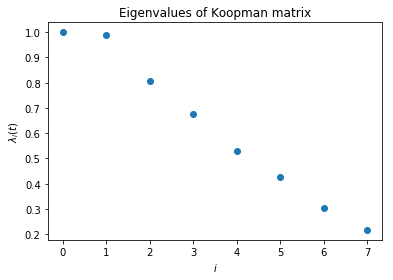

In [17]:
# Diagonalize K:
d, V = scl.eig(K)
# Sort eigenvalues and eigenvectors:
ind = np.argsort(d)[::-1]
d = d[ind]
V = V[:, ind]

plt.figure()
plt.plot(d, "o")
plt.xlabel(r"$i$")
plt.ylabel(r"$\lambda_i(t)$")
plt.title("Eigenvalues of Koopman matrix")

Infer the implied relaxation timescales from the eigenvalues of your Koopman matrix. These are defined as
$$ t_k = -\frac{t}{\log(\lambda_k(t))}$$

In [18]:
# Determine timescales:
print("Implied timescales: ")
its = - (dt*tau) / np.log(d[1:])
print(its)

Implied timescales: 
[5.07800074-0.j 0.23087821-0.j 0.12800496-0.j 0.07896099-0.j
 0.05844724-0.j 0.04202169-0.j 0.03271253-0.j]


### Finding Structure based on the Koopman matrix

We will now use the Koopman matrix to identify long-lived parts of the state space. 

In [19]:
# Evaluate the first two eigenfunctions on a grid:
xp = np.arange(-1.5, 1.51, 0.05)
PX = _psi(xp)
VX = np.dot(V[:, :2].T, np.dot(L.T, PX))
VX[0, :] = np.mean(VX[0, :])

In [20]:
# Apply PCCA:
chi, A = _pcca_connected_isa(VX.T, n_clusters=2)

Text(0.5, 1.0, 'Memberships for Macrostates')

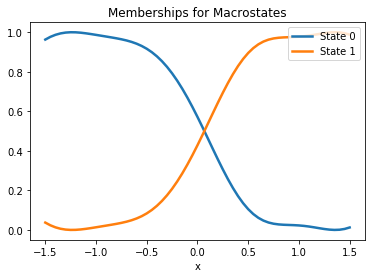

In [21]:
# Evaluate membership functions on a grid:
chi_p = np.dot(A.T, VX)
for k in range(2):
    plt.plot(xp, chi_p[k, :], linewidth=2.5, label="State %d"%k)
plt.legend(loc=1)
plt.xlabel("x")
plt.title("Memberships for Macrostates")